## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import _pickle
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
import time
import os
import peakutils
from sklearn.mixture import GaussianMixture as GMM


from ourfunctions_v3 import clean_nan_samples, remove_noise, interpolate_spectra, spectrum_in_bins_3

## Important Preprocessing parameters

In [22]:
m = 2000; M = 12000; 
bin_size = 4
step_size = 1; # interpolation step size

# path = "D:/GitHub/Machine-Learning/Kaggle/"
path = 'C:/Users/Javi/Documents/GitHub/Machine-Learning/Kaggle/'

## Load and clean data

In [3]:
savepath = path + 'Kaggle classifiers/bin size 5/'
path_results = path + 'Kaggle_results/'

ncpu = os.cpu_count()
if (ncpu>2): njobs = ncpu - 2; 
else: njobs = 1;
    
zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
df_train = _pickle.loads(zf.open('TrainData.pkl').read())
zf.close()

zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read())
zf.close()

df_train = remove_noise(df_train)

Training sample 339  eliminated
Training sample 490  eliminated


## Divide data in test and train
Also binning spectrum, normalize and remove baseline.

In [23]:
# Extract data (spectra) and targets of the df_train set
data = df_train.iloc[:,-2:]
targets = df_train.iloc[:,1:-2]

# Then, split into a train and test_train set
data_train, data_test_train, targets_train, targets_test_train = train_test_split(data, targets, test_size=0.2, random_state=0) # split the data
print('Training samples: '+str(len(data_train))+' and test_train samples: ' + str(len(data_test_train)) )

# apply the bins to all spectra, so that our feature space becomes the same for all samples (make them regular, all the same)
spectrum_train = spectrum_in_bins_3(data_train,m,M,bin_size)
spectrum_test_train = spectrum_in_bins_3(data_test_train,m,M,bin_size)
print('Spectrum interpolated!')
# these spectrum_... are our X for training

Training samples: 411 and test_train samples: 103
Spectrum interpolated!


## Peak detection algorithms
We can consider different peak detection algorithms:
* Gaussian Mixture Model: although slower, it is supposedly more accurate and appropiate. When using a low count level, the algorithm is fast and detects most peaks. However, many times their mean is somehow displaced. This would need to be corrected by looking at the maximum value in the vicinity. On the other hand, when using a higher count level (smaller single sample value, and more elements in samples_vector), the algorithm takes much more time, and also BIC indicates much larger values of N_COMPONENTS than what it should, leading to detection of many false peaks.
* PeakUtils peak detection: this function is actually working pretty well, although I think it is based on thresholding. Nonetheless, with a threshold of 0.05, is detecting very accurately most peaks and not giving too many false positives.
* FindPeaksCWT is another option for peak detection, although more sensitive to window size. Yesterday, I found bin_size = 5 and window_width = 3 to be a good combination.

In any case, after finding the peaks in the mean spectra, a new set of features should be built by getting the values of each spectrum at those positions (or nearby, in the case of inaccurate GMM). This will lead to a much lower number of features, and therefore to faster, less noisy classification. Anyway, a feature reduction step should be implemented.

First of all, let's get the mean spectrum:

In [24]:
mean_spectrum = np.mean(spectrum_train.to_numpy(),axis=0)

### PeakUtils

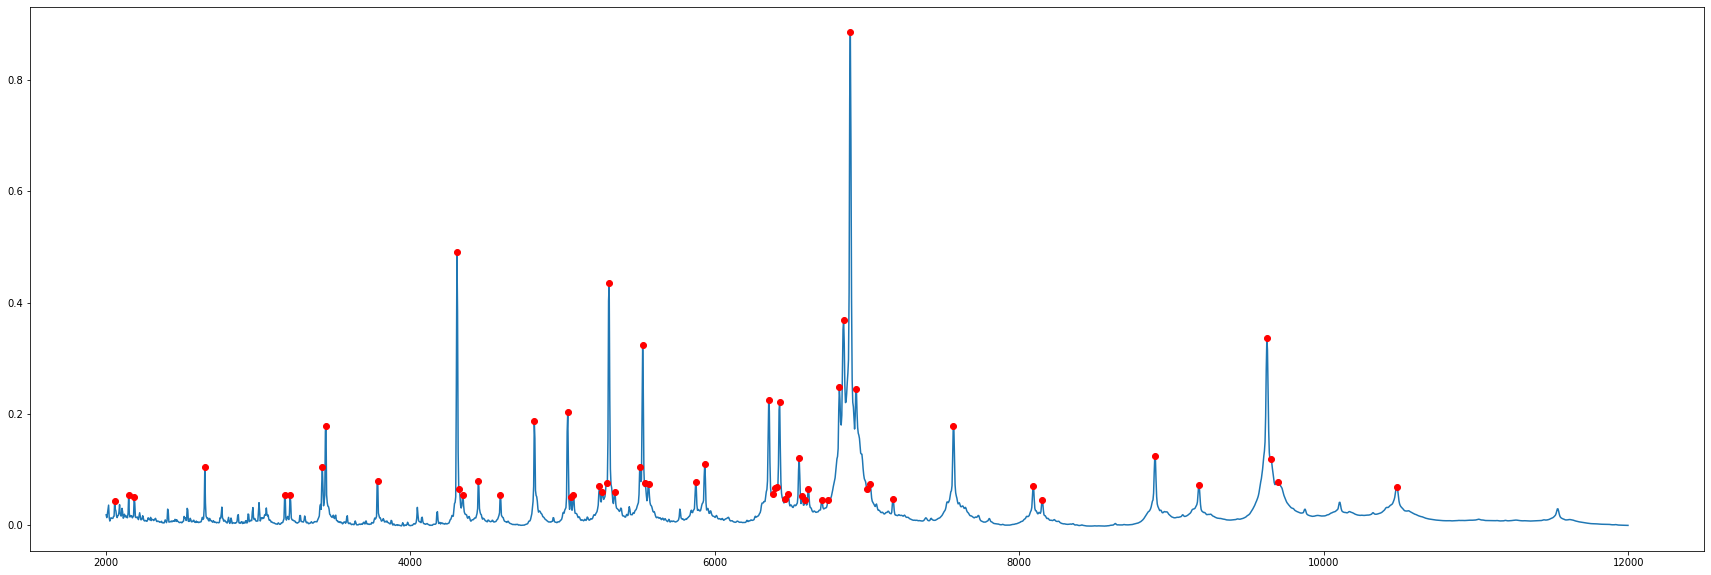

In [56]:
peaks = peakutils.peak.indexes(mean_spectrum,thres=0.05)

plt.figure(figsize=(30,10))
plt.plot(spectrum_train.columns.values,mean_spectrum)
plt.plot(spectrum_train.columns.values[peaks],mean_spectrum[peaks],'ro')
plt.show()

In [57]:
def spectrum_in_peaks(spectrum,peaks):
    df = spectrum.copy()
    spectrum  = spectrum.to_numpy()
    new_spectrum = np.zeros((spectrum.shape[0],len(peaks)))
    
    for i,x in enumerate(spectrum):
      spectrum_train_aux = x[peaks]
      new_spectrum[i,:] = spectrum_train_aux

    new_df = pd.DataFrame(data=new_spectrum, columns = df.columns.values[peaks], index = df.index)
    return new_df

peaks_spectrum_train = spectrum_in_peaks(spectrum_train, peaks)
peaks_spectrum_test_train = spectrum_in_peaks(spectrum_test_train, peaks)

## Low-area peak extraction
The idea is that most information may lie in the low area, but they are very low in amplitude, so they are not being detected right now. Therefore, let's get spectra in that area and attach those peaks to the other peaks. **For the moment, we will not bother with the fact that we will be normalizing by different values. Maybe later**

In [31]:
def spectrum_in_bins_4(df, m, M, bin_size): # first remove baseline and then normalization
    # Now, let's define the mz ranges, and the label associated to each of them (the mean of the limiting values of each bin)
    range_min = []; range_max = []; range_mean = []
    for mz in range(m,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_mean.append(np.mean([range_min[-1],range_max[-1]]).astype(int))
    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    for idx in range(N):
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((1,L))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[0,i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[0,i] = np.interp(x=range_mean[i],xp=mzcoord,fp=intensity)

        # Remove baseline
        idx_data_in_bins[0,:] -= peakutils.baseline(idx_data_in_bins[0,:],deg=4)
        # Normalize the amplitude of the spectrum
        idx_data_in_bins[0,:] = idx_data_in_bins[0,:] / np.max(idx_data_in_bins[0,:])
        # Store in matrix
        all_data[idx,:] = idx_data_in_bins
    new_df = pd.DataFrame(data=all_data, columns = range_mean, index = df.index)
    return new_df

In [32]:
spectrum_train_lowarea = spectrum_in_bins_4(data_train,2000,4000,2)
# spectrum_test_train_lowarea = spectrum_in_bins_3(data_test_train,2000,4000,2)
print('Spectrum interpolated!')

Spectrum interpolated!


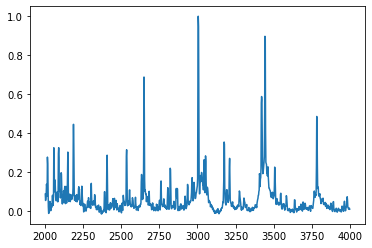

In [33]:
plt.plot(spectrum_train_lowarea.iloc[5,:])

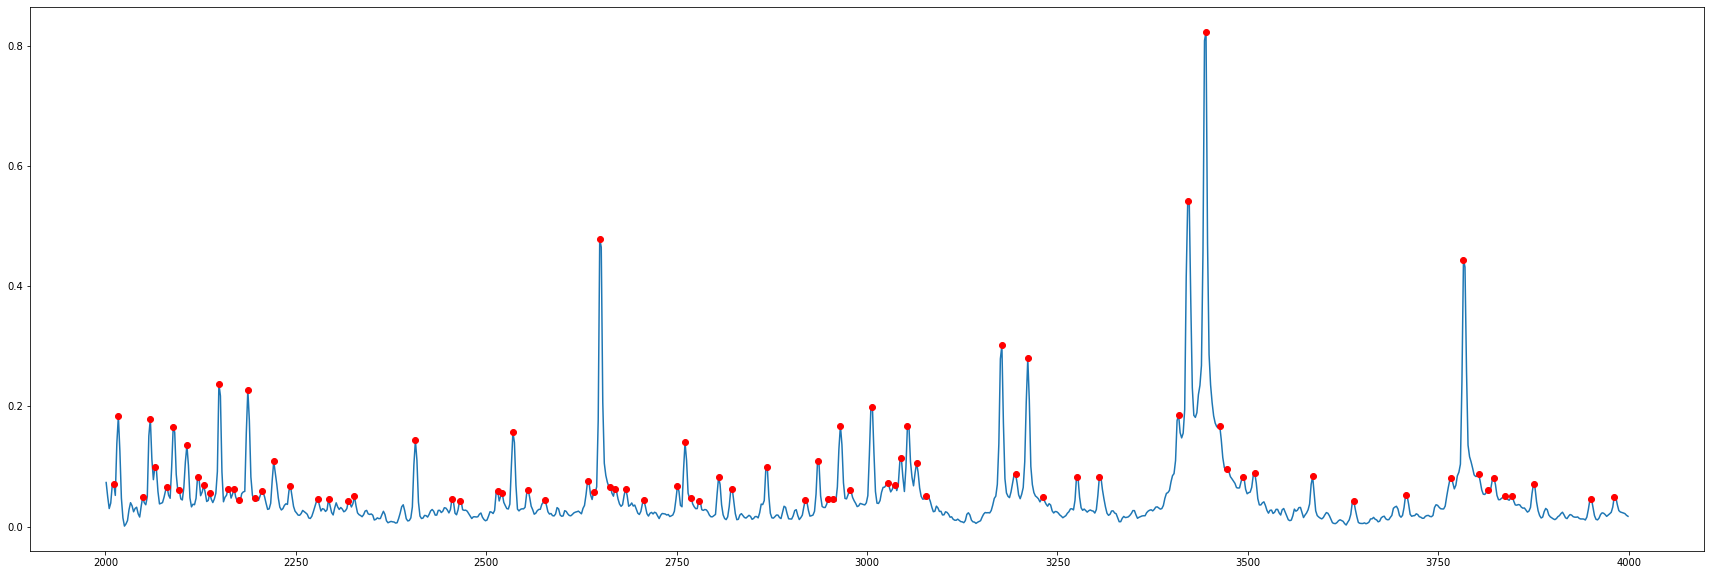

In [34]:
mean_spectrum_lowarea = np.mean(spectrum_train_lowarea.to_numpy(),axis=0)

peaks_lowarea = peakutils.peak.indexes(mean_spectrum_lowarea,thres=0.05)

plt.figure(figsize=(30,10))
plt.plot(spectrum_train_lowarea.columns.values,mean_spectrum_lowarea)
plt.plot(spectrum_train_lowarea.columns.values[peaks_lowarea],mean_spectrum_lowarea[peaks_lowarea],'ro')
plt.show()

In [35]:
peaks_spectrum_train_lowarea = spectrum_in_peaks(spectrum_train_lowarea,peaks_lowarea)

In [45]:
print(peaks_spectrum_train.shape)
peaks_spectrum_train.head()

(411, 58)


,2058,2150,2186,2650,3178,3210,3422,3446,3786,4306,...,7170,7566,8090,8150,8890,9178,9626,9650,9702,10478
ID,,,,,,,,,,,,,,,,,,,,,
297,0.029001,0.039038,0.036393,0.067914,0.047639,0.038483,0.077056,0.118296,0.057419,0.395430,...,0.035905,0.163055,0.064755,0.031946,0.108263,0.061626,0.274312,0.073776,0.053637,0.057139
311,0.134145,0.122495,0.147481,0.196382,0.136221,0.120991,0.252429,0.258000,0.217622,0.790086,...,0.106022,0.326981,0.158860,0.073664,0.268008,0.136372,0.466445,0.134648,0.097482,0.135182
298,0.024598,0.032559,0.029261,0.060990,0.040986,0.040132,0.079827,0.112490,0.043264,0.461703,...,0.052327,0.185261,0.097103,0.038135,0.121946,0.082002,0.261203,0.086458,0.068142,0.079406
71,0.043638,0.062986,0.054684,0.213435,0.078058,0.085562,0.161960,0.407008,0.137890,0.357558,...,0.048629,0.198355,0.070678,0.054898,0.142466,0.076793,0.479912,0.133504,0.081865,0.079425
170,0.005760,0.022680,0.008821,0.036699,0.082269,0.036116,0.092957,0.088497,0.079578,0.346567,...,0.053254,0.242473,0.074273,0.037982,0.111184,0.080732,0.396633,0.155965,0.104621,0.058637


In [44]:
print(peaks_spectrum_train_lowarea.shape)
peaks_spectrum_train_lowarea.head()

(411, 86)


,2011,2017,2049,2059,2065,2081,2089,2097,2107,2121,...,3767,3783,3803,3815,3823,3837,3847,3875,3951,3981
ID,,,,,,,,,,,,,,,,,,,,,
297,0.063771,0.046389,0.038063,0.191165,0.080693,0.050191,0.142419,0.040611,0.114436,0.039633,...,0.039043,0.485875,0.055075,0.039165,0.060969,0.042824,0.041248,0.045925,0.023235,0.021781
311,0.104424,0.143395,0.099035,0.454261,0.144909,0.104417,0.304297,0.065176,0.208008,0.062955,...,0.063134,0.804977,0.101257,0.077915,0.103232,0.052692,0.063942,0.036184,0.016227,0.030848
298,0.045259,0.153149,0.045419,0.152276,0.088376,0.071690,0.156243,0.051425,0.119673,0.095343,...,0.064065,0.483998,0.076430,0.056915,0.050687,0.053200,0.034361,0.103584,0.026000,0.047394
71,0.033458,0.044377,0.020370,0.099621,0.034336,0.030186,0.069721,0.029002,0.083791,0.022283,...,0.041982,0.334114,0.044231,0.025155,0.032354,0.027443,0.041569,0.035111,0.019618,0.037283
170,0.032900,0.101897,0.000433,0.019034,0.028231,0.051811,0.046985,0.020209,0.078310,0.046721,...,0.083584,0.378927,0.133157,0.090382,0.083101,0.046015,0.038816,0.107832,0.028852,0.028911


In [47]:
merged = pd.concat([peaks_spectrum_train,peaks_spectrum_train_lowarea],axis=1)

In [48]:
print(merged.shape)
merged.head()

(411, 144)


,2058,2150,2186,2650,3178,3210,3422,3446,3786,4306,...,3767,3783,3803,3815,3823,3837,3847,3875,3951,3981
ID,,,,,,,,,,,,,,,,,,,,,
297,0.029001,0.039038,0.036393,0.067914,0.047639,0.038483,0.077056,0.118296,0.057419,0.395430,...,0.039043,0.485875,0.055075,0.039165,0.060969,0.042824,0.041248,0.045925,0.023235,0.021781
311,0.134145,0.122495,0.147481,0.196382,0.136221,0.120991,0.252429,0.258000,0.217622,0.790086,...,0.063134,0.804977,0.101257,0.077915,0.103232,0.052692,0.063942,0.036184,0.016227,0.030848
298,0.024598,0.032559,0.029261,0.060990,0.040986,0.040132,0.079827,0.112490,0.043264,0.461703,...,0.064065,0.483998,0.076430,0.056915,0.050687,0.053200,0.034361,0.103584,0.026000,0.047394
71,0.043638,0.062986,0.054684,0.213435,0.078058,0.085562,0.161960,0.407008,0.137890,0.357558,...,0.041982,0.334114,0.044231,0.025155,0.032354,0.027443,0.041569,0.035111,0.019618,0.037283
170,0.005760,0.022680,0.008821,0.036699,0.082269,0.036116,0.092957,0.088497,0.079578,0.346567,...,0.083584,0.378927,0.133157,0.090382,0.083101,0.046015,0.038816,0.107832,0.028852,0.028911


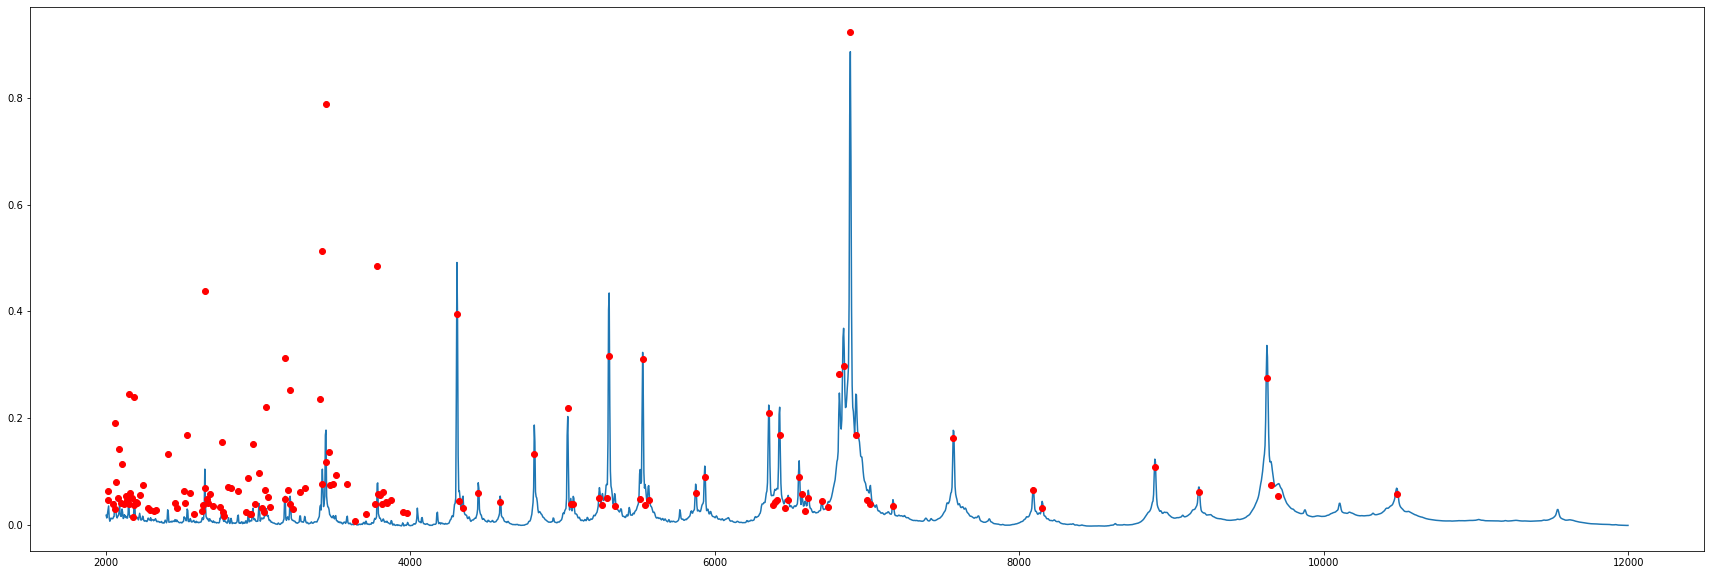

In [50]:
plt.figure(figsize=(30,10))
plt.plot(spectrum_train.columns.values,mean_spectrum)
plt.plot(merged.columns.values,merged.iloc[0,:],'ro')

## SVM
Now let's try with this new set of features (peaks) with a SVM.

In [51]:
spectrum_train_lowarea = spectrum_in_bins_4(data_train,2000,4000,2)
spectrum_test_train_lowarea = spectrum_in_bins_4(data_test_train,2000,4000,2)
print('Spectrum interpolated!')

Spectrum interpolated!


In [58]:
mean_spectrum_lowarea = np.mean(spectrum_train_lowarea.to_numpy(),axis=0)
peaks_lowarea = peakutils.peak.indexes(mean_spectrum_lowarea,thres=0.05)

peaks_spectrum_train_lowarea = spectrum_in_peaks(spectrum_train_lowarea,peaks_lowarea)
peaks_spectrum_test_train_lowarea = spectrum_in_peaks(spectrum_test_train_lowarea,peaks_lowarea)

merged_train = pd.concat([peaks_spectrum_train,peaks_spectrum_train_lowarea],axis=1)
merged_test_train = pd.concat([peaks_spectrum_test_train, peaks_spectrum_test_train_lowarea], axis=1)

In [65]:
def test_clf(df,n_fold,s_train, s_test_train, t_train, t_test_train, tuned_parameters):
  categories = df.columns[1:-2]
  clf_array =[]
  accuracy_array = []
  c_array =[]
  total_time = time.time()

  for c, cat in enumerate(categories): 
      start_time =time.time()
      X_train, Y_train = clean_nan_samples(s_train,t_train,c,cat)
      X_test, Y_test = clean_nan_samples(s_test_train,t_test_train,c,cat)
      clf  = GridSearchCV(SVC(class_weight='balanced', probability=True),iid=False,scoring='roc_auc',param_grid=tuned_parameters,
                        cv=n_fold, n_jobs = 3)
      clf.fit(X_train, Y_train)
      o_test = clf.predict_proba(X_test)[:,1]
      c_array.append(clf.best_params_)
      accuracy_array.append(roc_auc_score(Y_test,o_test))
      clf_array.append(clf)
      print(f'FINISHED {cat}, time{(time.time()-start_time)/60} minutes')

  print(f'Total time of execution: {(time.time() - total_time)/60} minutes')
  return clf_array, accuracy_array,c_array

In [70]:
from sklearn.svm import SVC
params = {'C':[0.1,0.5,1,5,10,20],'kernel':['linear']}
clf_array, accuracy_array_merged,c_array = test_clf(df_train, 3, merged_train, merged_test_train, targets_train, targets_test_train, params)

FINISHED OXACILINA, time0.014062488079071045 minutes
FINISHED AMIKACINA, time0.010156369209289551 minutes
FINISHED AMOXI/CLAV, time0.013281381130218506 minutes
FINISHED CIPROFLOXACINO, time0.013801689942677815 minutes
FINISHED CLINDAMICINA, time0.01302115519841512 minutes
FINISHED ERITROMICINA, time0.015364392598470052 minutes
FINISHED LEVOFLOXACINO, time0.014062293370564779 minutes
FINISHED PENICILINA, time0.01249993642171224 minutes
FINISHED TOBRAMICINA, time0.009635404745737711 minutes
Total time of execution: 0.11588511069615683 minutes


In [71]:
# and without merging
clf_array, accuracy_array,c_array = test_clf(df_train, 3, peaks_spectrum_train, peaks_spectrum_test_train, targets_train, targets_test_train, params)

FINISHED OXACILINA, time0.007031504313151042 minutes
FINISHED AMIKACINA, time0.006510063012441 minutes
FINISHED AMOXI/CLAV, time0.008072896798451742 minutes
FINISHED CIPROFLOXACINO, time0.007552023728688558 minutes
FINISHED CLINDAMICINA, time0.0072920004526774084 minutes
FINISHED ERITROMICINA, time0.008332967758178711 minutes
FINISHED LEVOFLOXACINO, time0.008072912693023682 minutes
FINISHED PENICILINA, time0.0072919925053914385 minutes
FINISHED TOBRAMICINA, time0.0065103689829508465 minutes
Total time of execution: 0.06692717870076498 minutes


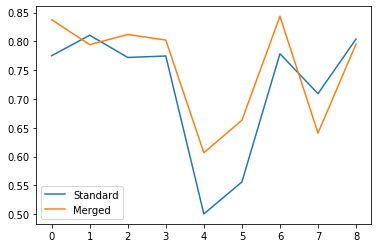

In [72]:
plt.plot(accuracy_array,label='Standard')
plt.plot(accuracy_array_merged,label='Merged')
plt.legend(); plt.show()

Now, let's take into account the normalization constant, using the same for both parts of the spectrum:

In [93]:
def merged_peaks_spectrums(df, m_lowarea, M_lowarea, bin_size_lowarea, threshold_lowarea, m, M, bin_size, threshold): 
    
    # SPECTRUM IN BINS FOR NORMAL RANGE
    range_min = []; range_max = []; range_mean = []
    for mz in range(m,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_mean.append(np.mean([range_min[-1],range_max[-1]]).astype(int))
           
    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    normaliz_cst = np.zeros((N,))
    for idx in range(N):
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((1,L))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[0,i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[0,i] = np.interp(x=range_mean[i],xp=mzcoord,fp=intensity)

        # Remove baseline
        idx_data_in_bins[0,:] -= peakutils.baseline(idx_data_in_bins[0,:],deg=4)
        # Normalize the amplitude of the spectrum
        normaliz_cst[idx] = np.max(idx_data_in_bins[0,:])
        idx_data_in_bins[0,:] = idx_data_in_bins[0,:] / normaliz_cst[idx]
        # Store in matrix
        all_data[idx,:] = idx_data_in_bins
    new_df = pd.DataFrame(data=all_data, columns = range_mean, index = df.index)
    
    
    # get peaks
    mean_spectrum = np.mean(spectrum_train.to_numpy(),axis=0)
    peaks = peakutils.peak.indexes(mean_spectrum,thres=threshold)
    peaks_spectrum = spectrum_in_peaks(new_df, peaks)    
    
    
    # VERY SIMILAR CODE FOR "LOW AREA"
    range_min_lowarea = []; range_max_lowarea = []; range_mean_lowarea = []
    for mz in range(m_lowarea,M_lowarea,bin_size_lowarea):
        range_min_lowarea.append(mz)
        range_max_lowarea.append(mz+bin_size_lowarea)
        range_mean_lowarea.append(np.mean([range_min_lowarea[-1],range_max_lowarea[-1]]).astype(int))
    N = len(df)  # number of samples
    L = len(range_min_lowarea)  # length of new spectrum (number of bins)
    all_data_lowarea = np.zeros((N,L))
    for idx in range(N):
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((1,L))
        for i,mz in enumerate(range_min_lowarea):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size_lowarea))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[0,i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[0,i] = np.interp(x=range_mean[i],xp=mzcoord,fp=intensity)

        # Remove baseline
        idx_data_in_bins[0,:] -= peakutils.baseline(idx_data_in_bins[0,:],deg=4)
        # Normalize the amplitude of the spectrum
        idx_data_in_bins[0,:] = idx_data_in_bins[0,:] / normaliz_cst[idx] # same normaliz_cst than on the other part of the spectrum
        # Store in matrix
        all_data_lowarea[idx,:] = idx_data_in_bins
    new_df_lowarea = pd.DataFrame(data=all_data_lowarea, columns = range_mean_lowarea, index = df.index)
    
    # get peaks_lowarea
    mean_spectrum_lowarea = np.mean(spectrum_train_lowarea.to_numpy(),axis=0)
    peaks_lowarea = peakutils.peak.indexes(mean_spectrum_lowarea,thres=threshold_lowarea)
    peaks_spectrum_lowarea = spectrum_in_peaks(new_df_lowarea, peaks_lowarea) 
    
    new_df_merged = pd.concat([peaks_spectrum,peaks_spectrum_lowarea],axis=1)
    return new_df_merged

In [94]:
# let's check if we get exactly the same than before
new_merged = merged_peaks_spectrums(data_train, 2000, 4000, 2, 0.05, m, M, bin_size, threshold=0.05)

# m = 2000; M = 12000; 
# bin_size = 4
# 0.05

# spectrum_train_lowarea = spectrum_in_bins_4(data_train,2000,4000,2)
# peaks_lowarea = peakutils.peak.indexes(mean_spectrum_lowarea,thres=0.05)

In [83]:
merged_train.head()

,2058,2150,2186,2650,3178,3210,3422,3446,3786,4306,...,3767,3783,3803,3815,3823,3837,3847,3875,3951,3981
ID,,,,,,,,,,,,,,,,,,,,,
297,0.029001,0.039038,0.036393,0.067914,0.047639,0.038483,0.077056,0.118296,0.057419,0.395430,...,0.039043,0.485875,0.055075,0.039165,0.060969,0.042824,0.041248,0.045925,0.023235,0.021781
311,0.134145,0.122495,0.147481,0.196382,0.136221,0.120991,0.252429,0.258000,0.217622,0.790086,...,0.063134,0.804977,0.101257,0.077915,0.103232,0.052692,0.063942,0.036184,0.016227,0.030848
298,0.024598,0.032559,0.029261,0.060990,0.040986,0.040132,0.079827,0.112490,0.043264,0.461703,...,0.064065,0.483998,0.076430,0.056915,0.050687,0.053200,0.034361,0.103584,0.026000,0.047394
71,0.043638,0.062986,0.054684,0.213435,0.078058,0.085562,0.161960,0.407008,0.137890,0.357558,...,0.041982,0.334114,0.044231,0.025155,0.032354,0.027443,0.041569,0.035111,0.019618,0.037283
170,0.005760,0.022680,0.008821,0.036699,0.082269,0.036116,0.092957,0.088497,0.079578,0.346567,...,0.083584,0.378927,0.133157,0.090382,0.083101,0.046015,0.038816,0.107832,0.028852,0.028911


In [95]:
new_merged.head()

,2058,2150,2186,2650,3178,3210,3422,3446,3786,4306,...,3767,3783,3803,3815,3823,3837,3847,3875,3951,3981
ID,,,,,,,,,,,,,,,,,,,,,
297,0.030107,0.040491,0.037778,0.070449,0.049727,0.040299,0.080130,0.122652,0.059990,0.408579,...,0.006050,0.075294,0.008535,0.006069,0.009448,0.006636,0.006392,0.007117,0.003601,0.003375
311,0.143766,0.131437,0.157995,0.210150,0.146455,0.130290,0.269980,0.275907,0.233130,0.841365,...,0.017532,0.223537,0.028118,0.021637,0.028667,0.014632,0.017756,0.010048,0.004506,0.008566
298,0.025781,0.034117,0.030709,0.063972,0.043437,0.042564,0.083941,0.117919,0.046068,0.481404,...,0.009808,0.074094,0.011701,0.008713,0.007760,0.008144,0.005260,0.015857,0.003980,0.007255
71,0.044894,0.064797,0.056229,0.219679,0.080061,0.087789,0.166483,0.418999,0.141636,0.367964,...,0.017566,0.139800,0.018507,0.010525,0.013538,0.011483,0.017393,0.014691,0.008209,0.015600
170,0.006376,0.024418,0.009716,0.039629,0.088333,0.039308,0.099804,0.095076,0.085741,0.369618,...,0.018605,0.084344,0.029639,0.020118,0.018497,0.010242,0.008640,0.024002,0.006422,0.006435


In [98]:
np.all(new_merged.columns.values == merged_train.columns.values)

True

In [99]:
new_merged_test_train = merged_peaks_spectrums(data_test_train, 2000, 4000, 2, 0.05, m, M, bin_size, threshold=0.05)
clf_array, accuracy_array_merged_new,c_array = test_clf(df_train, 3, new_merged, new_merged_test_train, targets_train, targets_test_train, params)

ValueError: Found input variables with inconsistent numbers of samples: [103, 411]

In [ ]:
# lets check how results are now:

It looks pretty well. Nevertheless, we should reduce dimensionality, at least for GPs. So let's use PCA, that seems easier to work with: